# Basic Network

## 1. Two coplanar circular orbits

In the following section we will focus on a toy model of our problem : two coplanar circular orbits, one LEO and one MEO orbit.
The following algorithms are constructed as descripted in the *Multi-orbit routing and scheduling paper.*


In [1]:
#Import packages

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

In [2]:
#Define useful constants

mu = 398600     #Earth’s gravitational parameter in [km³∕s²]
T = 86400      #setting the time horizon [s]
dT = 900    #setting the discretization step of our time horizon [s]

We begin with implementing a useful set of classes for our objects  later on

A faire : créer une database imitant la structure de Table 1 dans le papier, afin de garder une trace de :
 - L'orbite à laquelle appartient chaque noeud
 - La période et l'espacement des noeuds

In [3]:
class Orbit :
    def __init__(self,
                 id: int,
                 orbital_period: float,
                 time_unit_duration: int
                 ) :
        self.id = id
        self.Torb = orbital_period
        self.dt = time_unit_duration*dT
        self.r = ((mu * orbital_period**2)/(4*np.pi**2))**(1/3)
    def __str__(self) -> str:
        return f"Orbit {self.id}"


class Task :
    def __init__(self,
                 id: int,
                 orbit: Orbit,
                 true_anomaly: float
                 ) :
        self.id = id
        self.orbit = orbit
        self.theta = true_anomaly
    def __str__(self) -> str:
        return f"Task {self.id}"

class Node :
    def __init__(self,
                 id: int,
                 orbit: Orbit,
                 true_anomaly: float
                 ) :
        self.id = id
        self.orbit = orbit
        self.theta = true_anomaly
    def __str__(self) :
        return f"Node {self.id}"
    

class Arc :
    def __init__(self,
                 start_node: Node,
                 end_node: Node,
                 type: str,
                 tho: float,
                 phi: float
                 ) :
        self.start_node = start_node
        self.end_node = end_node
        self.type = type
        self.tho = tho
        self.phi = phi
    def __str__(self) -> str:
        return f"({self.start},{self.end},{self.type})"
    
class Network :
    def __init__(self,
                nodes: list[Node],
                arcs: list[Arc]
                ) -> None:
        self.nodes = nodes
        self.arcs = arcs
    # def __str__(self):
    #         nodes_str = '\n'.join(str(node) for node in self.nodes)
    #         arcs_str = '\n'.join(str(arc) for arc in self.arcs)
    #         return f"Nœuds:\n{nodes_str}\nArcs:\n{arcs_str}"
    def __str__(self) -> str:
        return f"{np.size(self.nodes)} Nodes and {np.size(self.arcs)} Arcs"
    

    def draw_curved_arrow(self, 
                          start_node: Node, 
                          end_node: Node, 
                          arc_type: str
                          ):
        
        #Warning : the angle theta is an orbital angle in the clockwise direction, so we have to use -theta for the trigonometric direction
        start_x = start_node.orbit.r * np.cos(-start_node.theta*np.pi/180)
        start_y = start_node.orbit.r * np.sin(-start_node.theta*np.pi/180)
        end_x = end_node.orbit.r * np.cos(-end_node.theta*np.pi/180)
        end_y = end_node.orbit.r * np.sin(-end_node.theta*np.pi/180)


        # Calculate the midpoint and distance between nodes
        mid_x = (start_x + end_x) / 2
        mid_y = (start_y + end_y) / 2
        distance = np.sqrt((end_x - start_x) ** 2 + (end_y - start_y) ** 2)

        # Fixed displacement for the curve, calculating the angle alpha compared to the horizontal

        displacement = distance/10 * np.sqrt(np.sin(np.linspace(0,np.pi,100)))
        alpha = math.atan2((end_y-start_y),(end_x-start_x))

        curve_x = np.linspace(start_x, end_x, 100) - displacement * np.sin(alpha)
        curve_y = np.linspace(start_y, end_y, 100) + displacement * np.cos(alpha)

        ctype = {'Orbital_maneuver' : 'blue',
                 'Phasing_maneuver' : 'green',
                 'Hohmann_transfer' : 'red'}

        # Plotting the curve
        plt.plot(curve_x, curve_y, linewidth=1, color = ctype[arc_type])

        # Add an arrow at the end
        arrow = FancyArrowPatch((curve_x[-1], curve_y[-1]), 
                                (end_x, end_y), 
                                arrowstyle='->', 
                                color='blue', 
                                mutation_scale=10)
        plt.gca().add_patch(arrow)
    
    def visualize(self, arc_types_to_display):
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

        # Plot nodes
        for node in self.nodes:
            x = node.orbit.r * np.cos(-node.theta*np.pi/180)
            y = node.orbit.r * np.sin(-node.theta*np.pi/180)
            if node.id == 0 :
                plt.plot(x, y, 'o', markersize=8, color = 'red')
            else :
                plt.plot(x, y, 'o', markersize=8, color = 'black')


        # Plot arcs based on types

        for arc in self.arcs:
            if arc.type in arc_types_to_display:
                self.draw_curved_arrow(arc.start_node,arc.end_node,arc.type)

        plt.xlim(-max(node.orbit.r for node in self.nodes) - 1, max(node.orbit.r for node in self.nodes) + 1)
        plt.ylim(-max(node.orbit.r for node in self.nodes) - 1, max(node.orbit.r for node in self.nodes) + 1)
        plt.axhline(0, color='black',linewidth=0.5, ls='--')
        plt.axvline(0, color='black',linewidth=0.5, ls='--')
        plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Network Visualization")
        plt.show()

Then we are going to define functions to create the orbital maneuvers needed for the problem. Since we consider two coplanar orbits, we do not have to implement the Hohmann transfer with inclination change maneuver.

In [4]:
import math

def orbital_maneuver(N1: Node,
                     N2: Node
                     ) :
    dtheta = (N2.theta - N1.theta)%360
    time_duration = dtheta/360 * N1.orbit.Torb/dT
    return Arc(start_node=N1,end_node=N2,type='Orbital_maneuver',tho=time_duration,phi=0)
    

def phasing_maneuver(N1: Node, 
                     N2: Node, 
                     k=1
                     ):
    # Calcul du changement d'anomalie vraie (en radians)
    theta_i = N1.theta
    theta_j = N2.theta

    if theta_j - theta_i < 0:
        delta_phi = (360 + (theta_j - theta_i)) * (math.pi / 180)
    else:
        delta_phi = (theta_j - theta_i) * (math.pi / 180)

    # Mouvement moyen
    n = math.sqrt(mu / N1.orbit.r**3)

    # Période de l'ellipse de phasage
    T_phasing_ellipse = (2 * k * math.pi + delta_phi) / (k * n)

    # Demi-grand axe de l'ellipse de phasage
    a_phasing_ellipse = ((mu * T_phasing_ellipse**2) / (4 * math.pi**2)) ** (1/3)

    # Changement de vitesse total
    delta_V = 2 * abs(
        math.sqrt(2 * mu / N1.orbit.r - mu / a_phasing_ellipse) - 
        math.sqrt(mu / N1.orbit.r)
    )

    # Temps pour compléter la manœuvre de phasage
    t_delta_phi = T_phasing_ellipse * (delta_phi / (2 * math.pi)) + k * T_phasing_ellipse

    return Arc(N1,N2,'Phasing_maneuver',t_delta_phi,delta_V)


def hohmann_transfer(N1: Node,
                     N2: Node
                     ):
    
    r1 = N1.orbit.r
    r2 = N2.orbit.r
    # Calcul du moment angulaire pour l'orbite de départ
    h1 = math.sqrt(mu * r1)  
    # Calcul du moment angulaire pour l'orbite de transfert
    h2 = math.sqrt(2 * mu * (r1 * r2 / (r1 + r2)))  
    # Calcul du moment angulaire pour l'orbite de destination
    h3 = math.sqrt(mu * r2)  

    # Vitesse à l'orbite de départ
    V1 = h1/r1
    # Vitesse à l'orbite de transfert
    V2 = h2/r1
    # Vitesse à l'orbite de destination
    V3 = h3/r2

    # Changement de vitesse pour la manœuvre
    delta_v1 = V2 - V1 
    delta_v2 = V3 - V2
    delta_V = abs(delta_v1) + abs(delta_v2)

    # Temps pour la manœuvre
    T = (2 * math.pi * (r2 ** 3/2) ) / math.sqrt(mu)

    return Arc(N1,N2,'Hohmann_transfer',T,delta_V)



Let's create our Network!

In [15]:
def node_creation(O: list[Orbit],
                  ) :
    N = []
    for o in O :
        sub = o.Torb//o.dt
        theta = 0
        for k in range(sub) :
            N.append(Node(id=k,orbit=o,true_anomaly=theta))
            theta+= 360/sub
    return N


def arc_creation(N: list[Node]) :
    A = []
    for N1 in N :
        for N2 in N :
            if N1 != N2 :
                dtheta = (N2.theta - N1.theta)%360
                if N1.orbit == N2.orbit :   #If nodes are on the same orbit
                    sub = N1.orbit.Torb//N1.orbit.dt
                    if dtheta == 360/sub :     #if nodes are adjacent in the direction of orbit
                        A.append(orbital_maneuver(N1,N2))
                    else :  #If nodes are not adjascent in the direction of orbit
                        A.append(phasing_maneuver(N1,N2))

                elif N1.orbit != N2.orbit and (N1.theta-N2.theta)%360 == 180 :
                    A.append(hohmann_transfer(N1,N2))
    return A

def add_sink(N: list[Node],
             A: list[Arc]
             ) :
    N.append(Node(id=-1,orbit=Orbit(0,0,0),true_anomaly=0))
    for N1 in N :
        if N1.id != -1 :
            A.append(Arc(N1,N[-1],'sink_node',0,0))  


In [18]:
O1 = Orbit(id=1,orbital_period=5400,time_unit_duration=1)
O2 = Orbit(id=2,orbital_period=43200,time_unit_duration=2)
O = [O1,O2]


N = node_creation(O)
A = arc_creation(N)

add_sink(N,A)

net = Network(N,A)

print(net)

31 Nodes and 624 Arcs


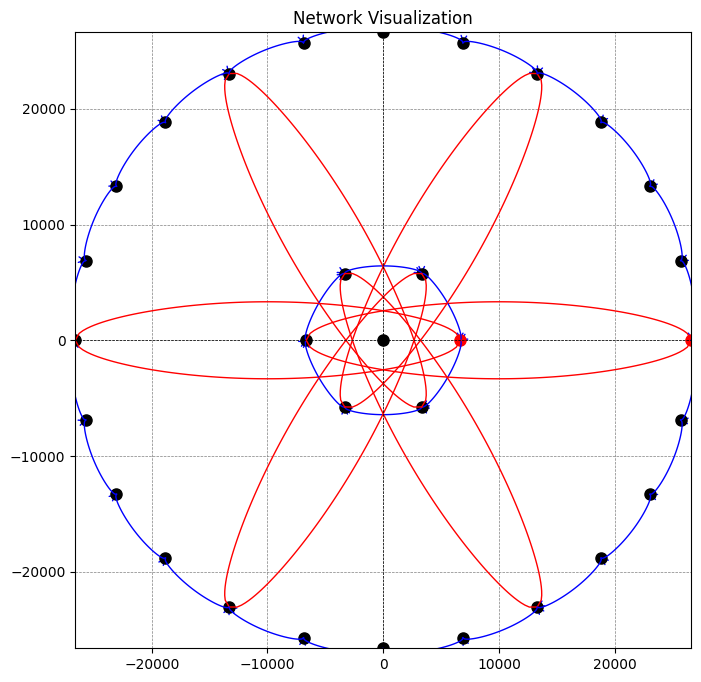

In [19]:
net.visualize(['Orbital_maneuver','Hohmann_transfer'])

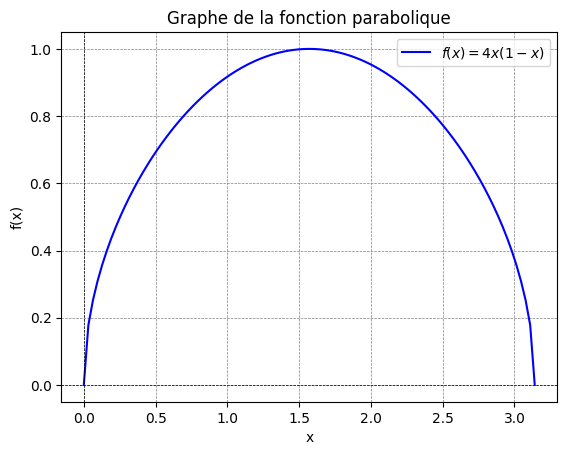

In [361]:
import numpy as np
import matplotlib.pyplot as plt




# Définir les valeurs de x
x = np.linspace(0, np.pi, 100)
y = np.sqrt(np.sin(x))

# Tracer le graphe
plt.plot(x, y, label=r'$f(x) = 4x(1 - x)$', color='blue')
plt.title('Graphe de la fonction parabolique')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.axhline(0, color='black',linewidth=0.5, ls='--')
plt.axvline(0, color='black',linewidth=0.5, ls='--')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()



The following model has more a general approach of defining the orbits and subdivisions, which we are not going to explore for now

In [97]:
# class Orbital_param_circ :
#     def __init__(self,
#                  orbit_id: int,
#                  semi_major_axis: float,
#                  true_anomaly: float
#                  ) :
#         self.orbit_id = orbit_id
#         self.r = semi_major_axis
#         self.theta = true_anomaly
#         if semi_major_axis > 0 :
#             self.Torb = (2*np.pi*semi_major_axis)/np.sqrt(mu/semi_major_axis)
#         else :
#             self.Torb=0

# class Node :
#     def __init__(self,
#                  id: int,
#                  orbital_param: Orbital_param_circ
#                  ) :
#         self.id = id
#         self.param = orbital_param

# class Task :
#     def __init__(self,
#                  id: int,
#                  time_unit_duration: int,
#                  orbital_param: Orbital_param_circ
#                  ) :
#         self.id = id
#         self.dt = time_unit_duration*dT

#         # if (orbital_param.Torb//time_duration) > 0 :
#         #     self.dt = orbital_param.Torb/(orbital_param.Torb//time_duration)  #Here we make the choice of wanting evenly spaced nodes around an orbit, and we approach the time duration of the task with the closest higher divider of the Time to orbit
#         # else : 
#         #     self.dt = np.inf

#         self.param = orbital_param

#     def angular_duration(self) :
#         return 360/(self.param.Torb/self.dt)


# class Arc :
#     def __init__(self,
#                  start: Node,
#                  end: Node,
#                  type: str
#                  ) :
#         self.start = start
#         self.end = end
#         self.type = type




**Warning:** In the following function *arc_creation*, the parameter theta is computed by dividing 360 with the number of nodes, which supposes that all nodes from one orbit are evenly distributed around the orbit! This may not be the case in reality

In [91]:
def node_creation(B: dict[Task],
                  T: float
                  ) -> list[Node] :
    """
    Inputs: 
        B: set of tasks
        T: Time horizon
    Outputs:
        N: Network of nodes
    """
    N=[]
    for v in B :
        orbit_id,r,theta,Torb = v.param.orbit_id,v.param.r, v.param.theta, v.param.Torb
        for k in range(int(Torb/v.dt)) :   #Pour chaque sous tâche, on crée un nouveau noeud
            dtheta = 360/(Torb/v.dt)
            theta+=dtheta   #Update the true anomaly theta at each node
            param = Orbital_param_circ(r,theta)
            N.append(Node(id=k,task_id=v.id,orbital_param=param))

    N.append(Node(0,Orbital_param_circ(0,0)))   #On rajoute le "sink node"
    return N


# def arc_creation(N: list[Node],T: float,dt: float) :
#     A = []
#     for N1 in N :
#         for N2 in N :
#             if N1.id != N2.id :
#                 dtheta = N2.param.theta - N1.param.theta  #theta correspond à l'angle entre les noeuds
#                 if N1.param.r == N2.param.r :   #If both nodes are on the same orbit
                    


SyntaxError: incomplete input (1712679715.py, line 24)

In [103]:
#One task Network

r = (mu * 5400**2 / (4*np.pi**2))**(1/3)

v = Task(id=1,time_unit_duration=1,orbital_param=Orbital_param_circ(orbit_id=1,semi_major_axis=r,true_anomaly=0))

B = {v}

v.param.Torb


np.float64(5399.999999999996)